# LFP dataset example

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import random
# Initialize the random seed to ensure reproducibility of the results in the paper
random.seed(10)
import jax.numpy as jnp
from src.featlin import Featlin
from src.featlin import jax_moment
from src.basis import BasicsData

plt.style.use('./styles/plots.mplstyle')

%load_ext autoreload
%autoreload 2

In [2]:
save_plots = 0
save_path = './results/Linearization/'

In [3]:
# Colorblind safe palette from: https://gka.github.io/palettes/#/26|s|00429d,96ffea,ffffe0|ffffe0,ff005e,93003a|1|1 
# IBM Colors: https://www.ibm.com/design/language/color/
# https://lospec.com/palette-list/ibm-color-blind-safe

colors = ['#332bb3', '#4a31b5', '#5d37b6', '#6d3db7', '#7c43b7', '#8a49b6', '#964fb5', '#a256b3', '#ad5db1', '#b764b0', '#c16cae', '#ca75ad', '#d27eac', '#d989ab', '#e094aa', '#e7a1ab', '#ecafac', '#f0beae', '#f4cfb0', '#f6e1b4']
colors_IBM = ['#648fff', '#785ef0', '#dc267f', '#fe6100', '#ffb000',  '#000000']
cmap_ = clr.LinearSegmentedColormap.from_list('Blue-light cb-safe', colors, N=256)
cmap = clr.LinearSegmentedColormap.from_list('Blue-light cb-IBM', colors_IBM[:-1], N=256)
color_list = [colors_IBM[0], colors_IBM[2], colors_IBM[3], colors_IBM[4], colors_IBM[5]]
marker_list = ['s', 'o', 'D', 'P']

In [4]:
# Load the LFP Dataset
lfp_df = pd.read_csv('./data/lfp_slim.csv', index_col=0)

X_lfp = np.array(lfp_df.iloc[:, 0:1000])
X_lfp = X_lfp[:, ::-1]
y_lfp_true = np.array(lfp_df.iloc[:, 1000])
x_lfp = np.linspace(2.0, 3.5, 1000)

X_lfp_train = np.array(X_lfp[lfp_df.iloc[:, 1002]==0, :])
y_lfp_train_true = np.array(y_lfp_true[lfp_df.iloc[:, 1002]==0])
X_lfp_test = np.array(X_lfp[lfp_df.iloc[:, 1002]==1, :])
y_lfp_test_true = np.array(y_lfp_true[lfp_df.iloc[:, 1002]==1])
X_lfp_test2 = np.array(X_lfp[lfp_df.iloc[:, 1002]==2, :])
y_lfp_test2_true = np.array(y_lfp_true[lfp_df.iloc[:, 1002]==2])

labels_lfp = {'xdata_label': 'Voltage (V)', 'ydata_label': r'$\Delta \mathbf{Q}_{100\mathrm{-}10}$ (Ah)', 'row_label': 'Battery number'}

In [5]:
# Remove outlier 
id_outlier = np.where(np.mean(X_lfp_train, axis=1)==np.min(np.mean(X_lfp_train, axis=1)))
X_lfp_train = np.delete(X_lfp_train, id_outlier, axis=0)
y_lfp_train_true = np.delete(y_lfp_train_true, id_outlier, axis=0)

# Ground Truth Features
- Mean 
- Varinace
- Sum of Squares
- Skewness


In [6]:
# True underlying relationship between the measurements and some quantity we ewould like to recover/predict from measurements

# JAX numpy wrapper target function  to allow for autodifferentiation
fun_targetj = [
    lambda a : jnp.mean(a),
    lambda a : jnp.sum(a**2),
    lambda a : jnp.var(a),
    lambda x: jax_moment(x,3)/((jax_moment(x,2))**(3/2)),
    lambda x: jax_moment(x,4)/(jax_moment(x,2)**2)-3
    ]
fun_target_names = [
    'Sum',
    'Sum of Squares',
    'Variance', 
    'Skewness',
    'Kurtosis',
    ]
feat_fun_dict = {fun_target_names[i] : fun_targetj[i] for i in range(len(fun_targetj))}

# What if the relationship is actually a combination fo different functions
# Combinations based of the functions above to obtain non-linear functions of different complexity
# This is expected to show limits of the methodology
fun_target_combj = [
    lambda  a : np.array(5*fun_targetj[0](a) + fun_targetj[1](a)),
    lambda  a : np.array(3*fun_targetj[2](a) + fun_targetj[0](a)),
    lambda  a : np.array(fun_targetj[1](a) * fun_targetj[3](a)),
    lambda  a : np.array(fun_targetj[3](a) * fun_targetj[4](a))
    ]
ftarget_comb_names = [
    '5*\sum_{i=1}^n x_i + \sum_{i=1}^n x_i^2',
    '3*\text{var}(\mathbf{x}) + \sum_{i=1}^n x_i',
    '\sum_{i=1}^n x_i^2 * \text{skewness}(\mathbf{x})',
    '\text{skewneww}(\mathbf{x}) * \text{kurtosis}(\mathbf{x})'
]

# X = X_lfp_train-np.mean(X_lfp, axis=0)
# y_gt = np.zeros([X.shape[0], 5, 1])
# for j in range(len(fun_targetj)): 
#     y_gt[:, j, 0] = generate_target_values(X[:, :], fun_targetj[j], percentage_range_x_to_t=[0,1], snr=50)

In [7]:
# Generate BasicsData class objects
lfp_mean = BasicsData(X=X_lfp_train, x=x_lfp, y=None) 
lfp_mean = lfp_mean.construct_y_data(fun_targetj[0]).add_wgn(add_noise_X=False, add_noise_y=True, snr_y=50)

# Mean
lfp_mean = BasicsData(X=X_lfp_train, x=x_lfp, y=None) 
lfp_mean = lfp_mean.construct_y_data(fun_targetj[0]).add_wgn(add_noise_X=False, add_noise_y=True, snr_y=50)

# Sinusoidal Feature
lfp_sin = BasicsData(X=X_lfp_train, x=x_lfp, y=None)
lfp_sin = lfp_sin.construct_y_data(lambda x: np.sin(2*np.pi*x)).add_wgn(add_noise_X=False, add_noise_y=True, snr_y=50)

# Sum Squares
lfp_sums = BasicsData(X=X_lfp_train, x=x_lfp, y=None) 
lfp_sums = lfp_sums.construct_y_data(fun_targetj[1]).add_wgn(add_noise_X=False, add_noise_y=True, snr_y=50)

# Variance
lfp_var = BasicsData(X=X_lfp_train, x=x_lfp, y=None) 
lfp_var = lfp_var.construct_y_data(fun_targetj[2]).add_wgn(add_noise_X=False, add_noise_y=True, snr_y=50)

# Skew
lfp_skew = BasicsData(X=X_lfp_train, x=x_lfp, y=None) 
lfp_lfp_skewvar = lfp_skew.construct_y_data(fun_targetj[3]).add_wgn(add_noise_X=False, add_noise_y=True, snr_y=50)

# Kurt
lfp_kurt = BasicsData(X=X_lfp_train, x=x_lfp, y=None) 
lfp_kurt = lfp_kurt.construct_y_data(fun_targetj[4]).add_wgn(add_noise_X=False, add_noise_y=True, snr_y=50)

In [8]:
# Inititate the class with data (x, y) & features that you want to test
lfp_meangt = Featlin(data_obj=lfp_mean, feat_funcs=feat_fun_dict)

Gamma value corresponding to nrmse=1.0e-01 % is 34.176
Gamma value corresponding to nrmse=1.0e-01 % is 577.001
Gamma value corresponding to nrmse=1.0e-01 % is 5738.795
Gamma value corresponding to nrmse=1.0e-01 % is 9883.407


KeyError: 'response'

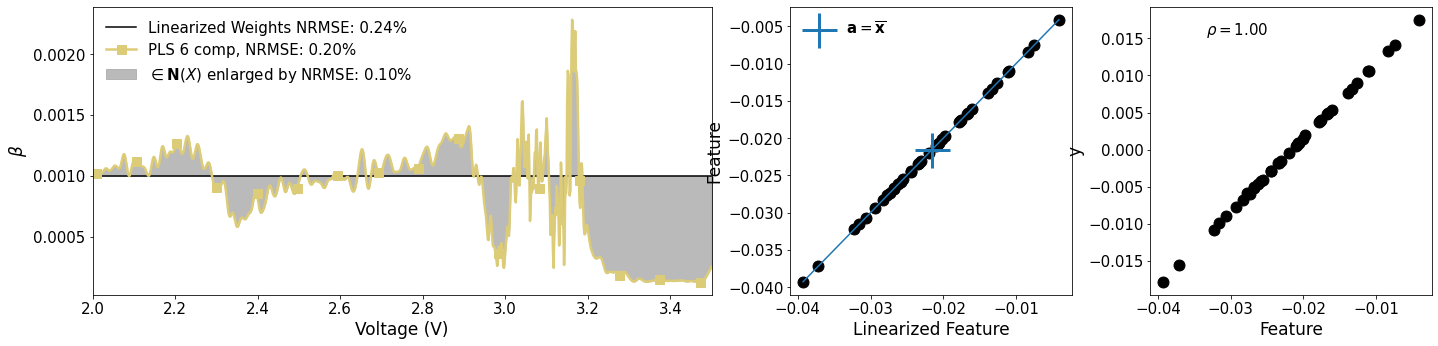

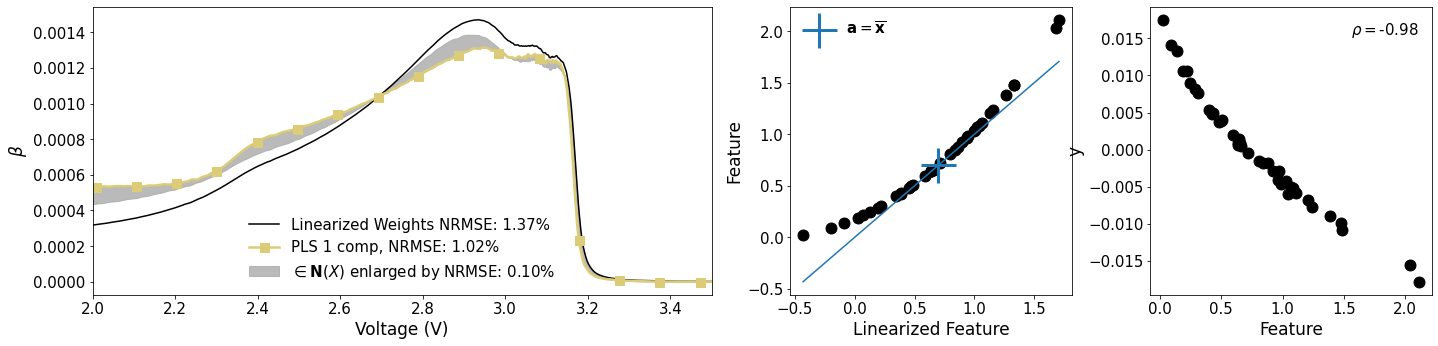

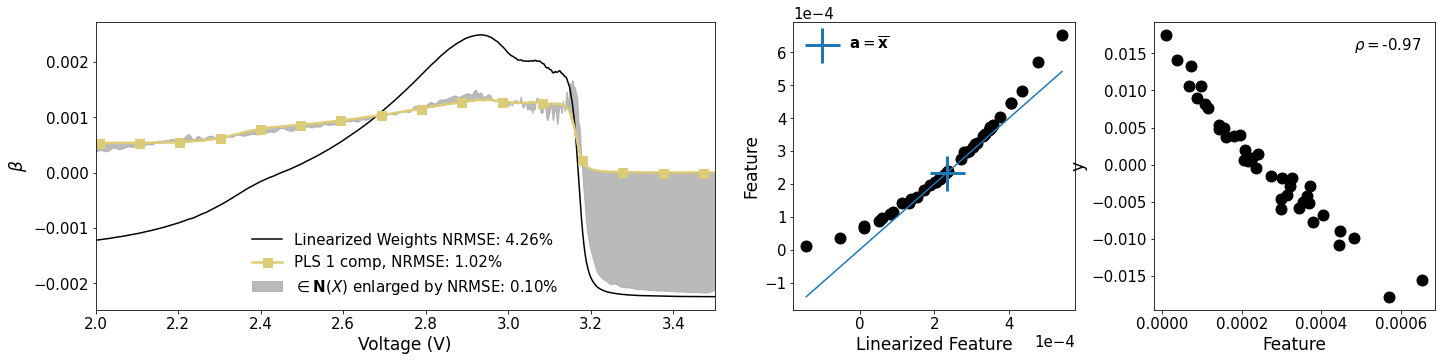

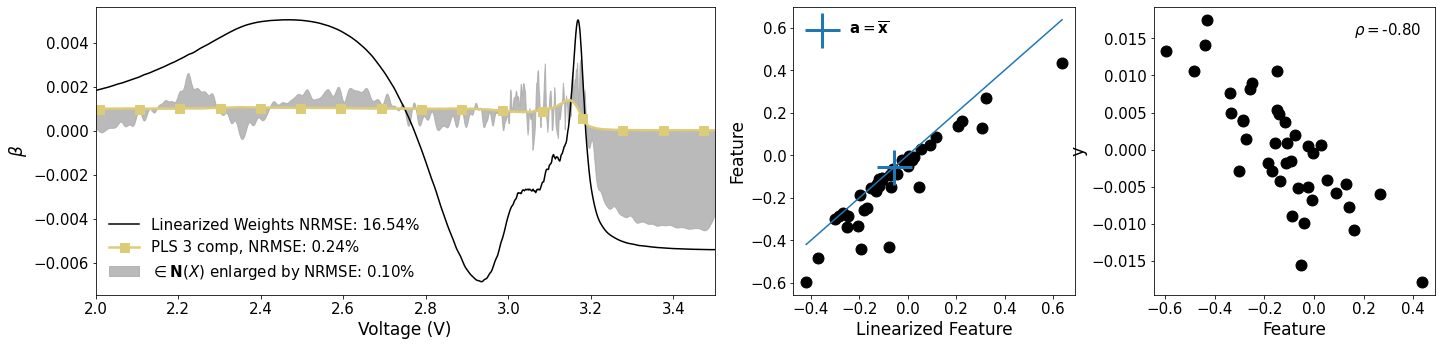

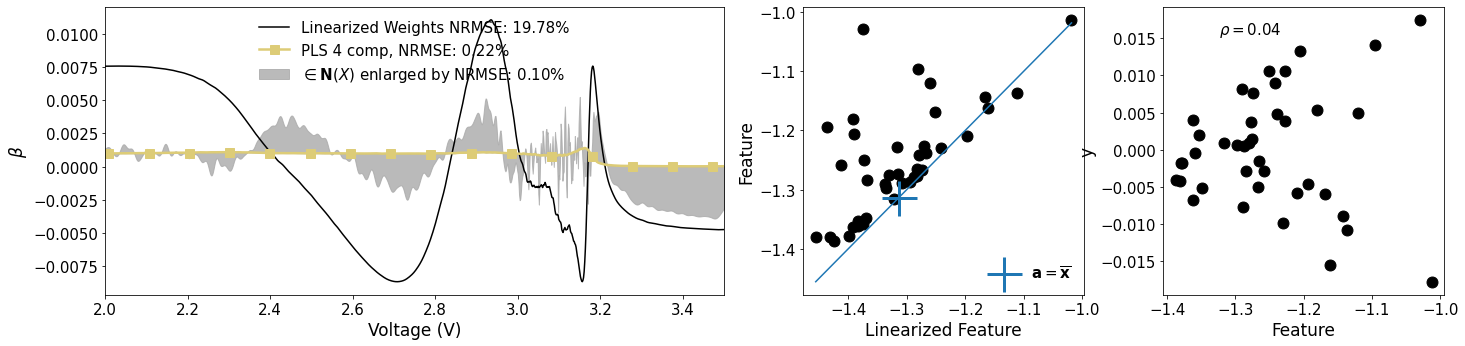

In [17]:
# Fix color here
# Make single plot look the same
# Include figure from other notebook. 

lfp_meangt = lfp_meangt.analyze_all_features(
    opt_cv={'active':False, 'model': []}, 
    opt_dist={'active':True, 'model': ['PLS']}, 
    max_nrmse=0.1, verbose=False)

In [10]:
# Then still the question remains, how to select the feature. 
# If the true feature is linear, easy. 
# If the true feature is nonlinear, then we're strongly limited
# By what we can show with thelinearized case.
# The linearized coefficients will make a mistake. 
# The nonlinear coefficients will make a mistake too. 
# Maybe we need to compare prediction between linearized 
# coefficients and regression coefficients? 

# Otherwise the meaning of thre prediction accouracy will be hard to compare. 

# Write functions that creates reuslts table: 

#Feature #NRMSE_Linearized #Closest_PLS_Model #NRMSE_PLS #Closest_RR_Model #NRMSE_RR #Pearson_Corr_Coefficient

# Assuming the featue IS the ground truth, which model predicts closes to it? 
# --> Select the feature! Which feature predicts closest to the linearized feature. Take th

# 1. Select with Pearson correlation coefficeints
# 2. Get insights into the feature with the linearization approach.
# 3. 


In [11]:
# 5. Show result table

Iteration: 0 done
Iteration: 1 done
Converged after 1 iterations
['PLS 1 comp', 'lfun']
Gamma value corresponding to nrmse=1.0e-01 % is 35.667
Iteration: 0 done
Iteration: 1 done
Converged after 1 iterations
['PLS 1 comp', 'lfun']
Gamma value corresponding to nrmse=1.0e-01 % is 24.808
Iteration: 0 done
Iteration: 1 done
Converged after 1 iterations
['PLS 1 comp', 'lfun']
Gamma value corresponding to nrmse=1.0e-01 % is 308.655
Iteration: 0 done
Iteration: 1 done
Converged after 1 iterations
['PLS 2 comp', 'lfun']
Gamma value corresponding to nrmse=1.0e-01 % is 904.399
Iteration: 0 done
Iteration: 1 done
Converged after 1 iterations
['PLS 2 comp', 'lfun']
Gamma value corresponding to nrmse=1.0e-01 % is 2767.937


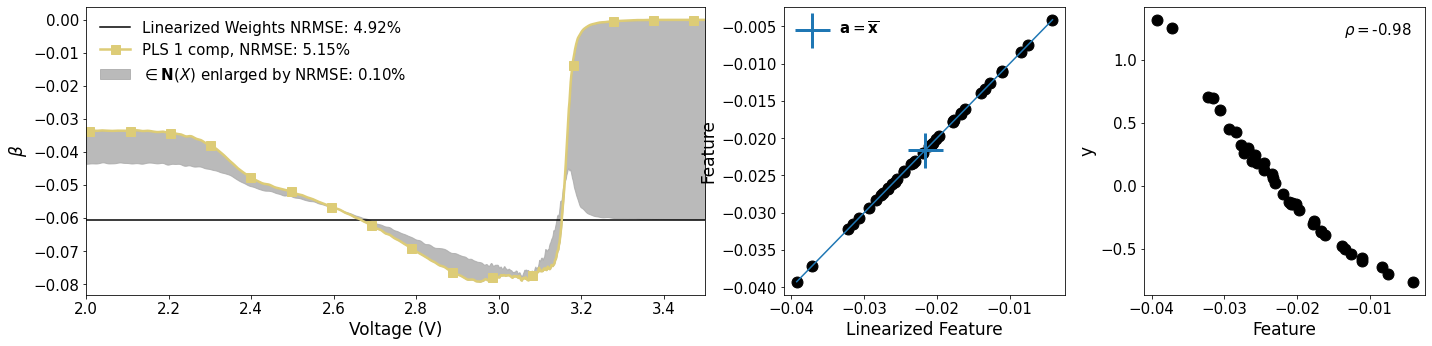

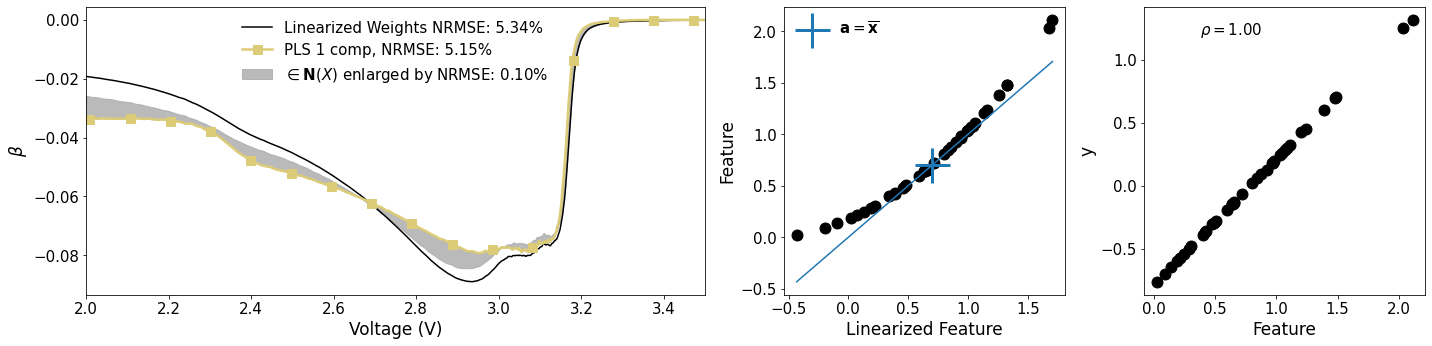

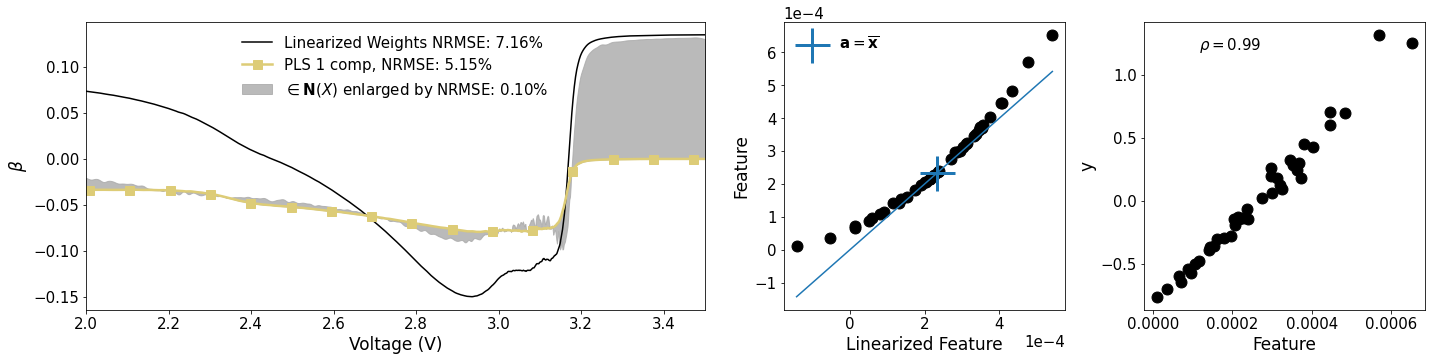

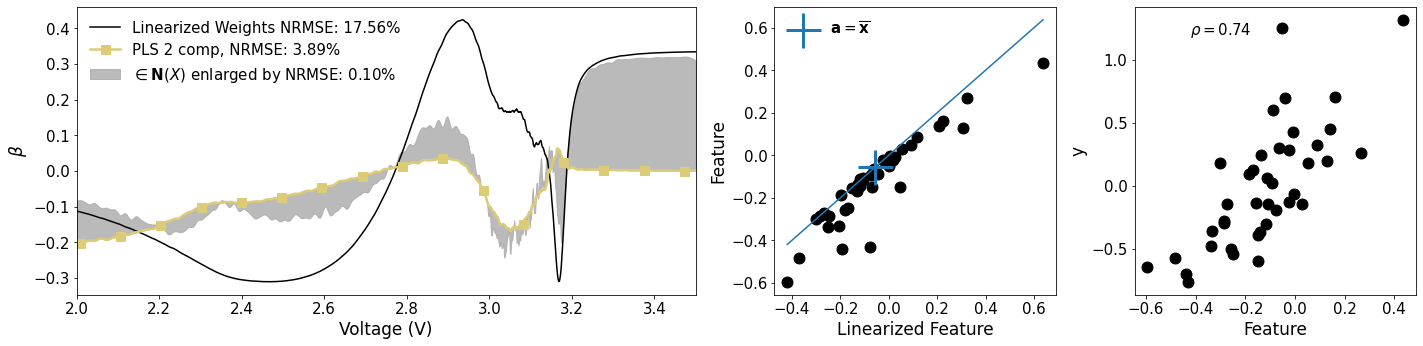

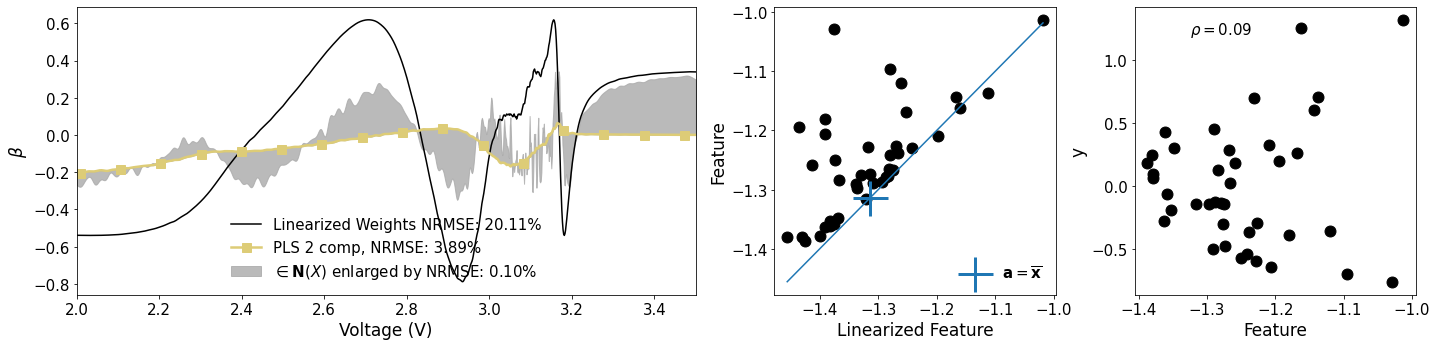

In [12]:
# Inititate the class with data (x, y) & features that you want to test
lfp_sums_gt = Featlin(data_obj=lfp_sums, feat_funcs=feat_fun_dict)

# Run the tests
lfp_sums_gt = lfp_sums_gt.analyze_all_features(opt_cv={'active':True, 'model': []}, opt_dist={'active':True, 'model': ['PLS']}, max_nrmse=0.1)
plt.show()

Iteration: 0 done
Iteration: 1 done
Iteration: 2 done
Converged after 2 iterations
['PLS 1 comp', 'lfun']
Gamma value corresponding to nrmse=1.0e-01 % is 40.233
Iteration: 0 done
Iteration: 1 done
Iteration: 2 done
Converged after 2 iterations
['PLS 1 comp', 'lfun']
Iteration: 0 done
Iteration: 1 done
Iteration: 2 done
Converged after 2 iterations
['PLS 2 comp', 'lfun']
Gamma value corresponding to nrmse=1.0e-01 % is 223.203
Iteration: 0 done
Iteration: 1 done
Iteration: 2 done
Converged after 2 iterations
['PLS 1 comp', 'lfun']
Gamma value corresponding to nrmse=1.0e-01 % is 265.967
Iteration: 0 done
Iteration: 1 done
Iteration: 2 done
Converged after 2 iterations
['PLS 1 comp', 'lfun']
Gamma value corresponding to nrmse=1.0e-01 % is 1779.019


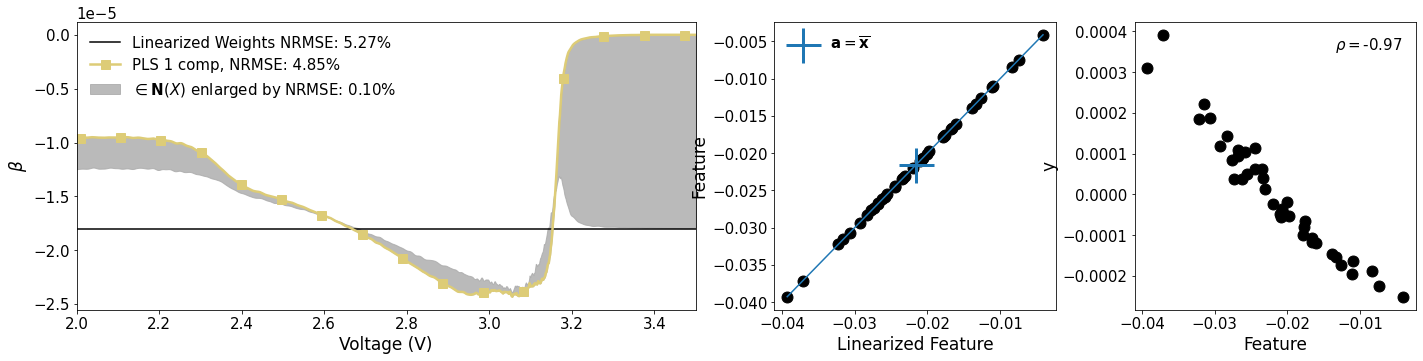

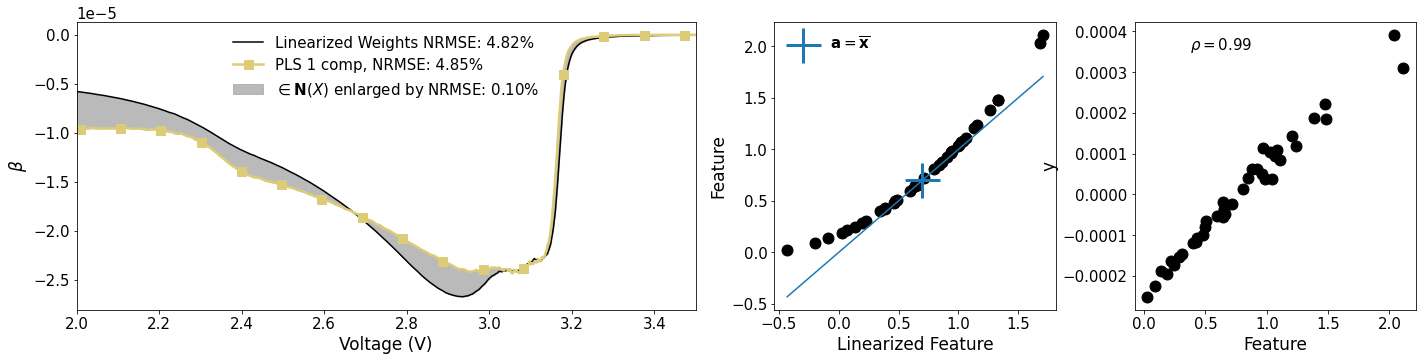

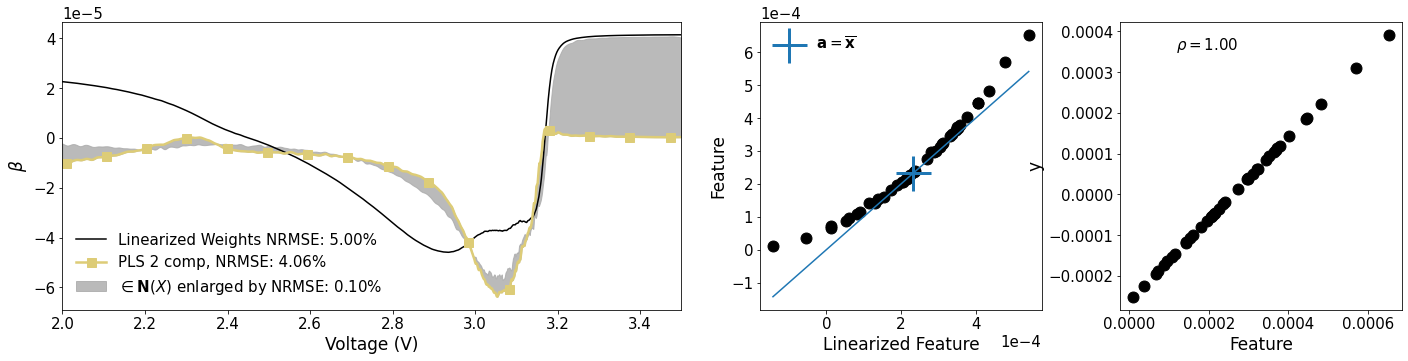

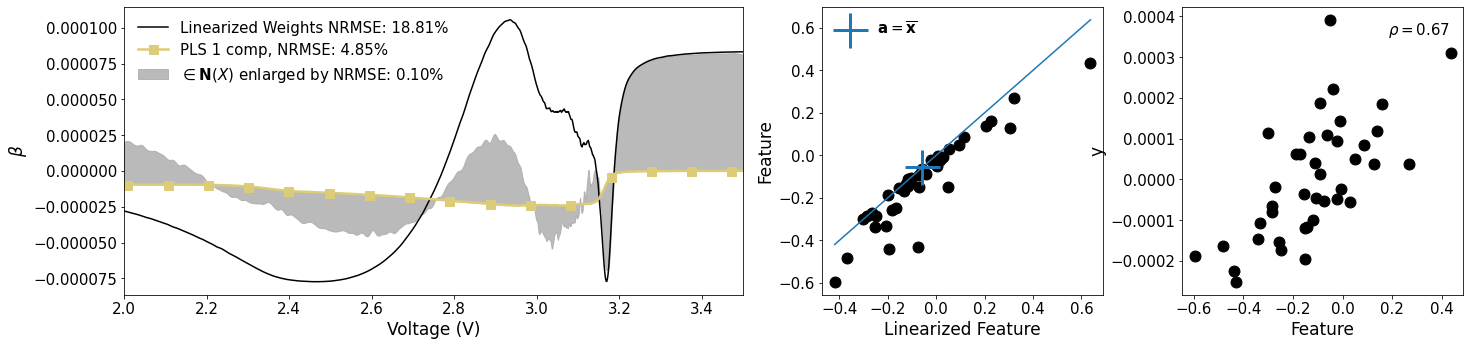

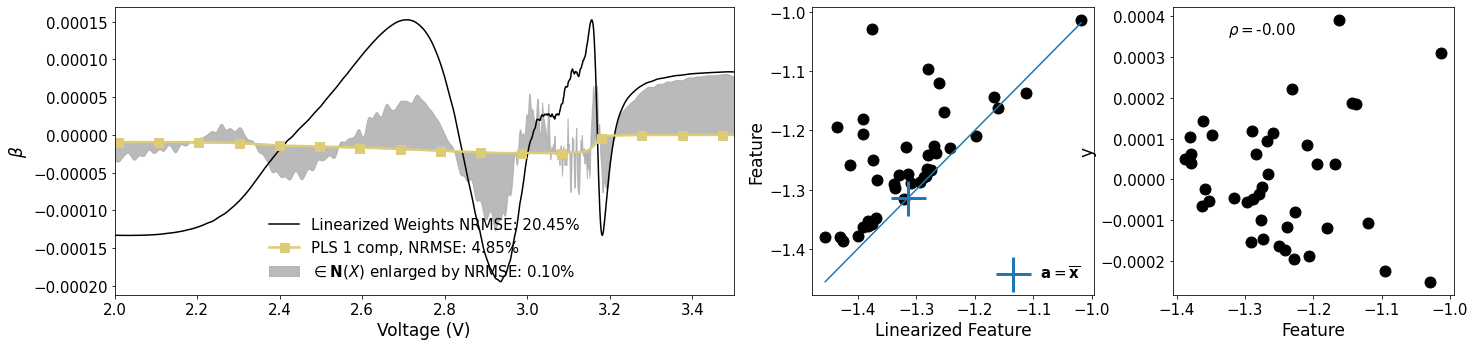

In [13]:
# Inititate the class with data (x, y) & features that you want to test
lfp_var_gt = Featlin(data_obj=lfp_var, feat_funcs=feat_fun_dict)

# Run the tests
lfp_var_gt = lfp_var_gt.analyze_all_features(opt_cv={'active':True, 'model': []}, opt_dist={'active':True, 'model': ['PLS']}, max_nrmse=0.1)
plt.show()

Iteration: 0 done
Iteration: 1 done
Iteration: 2 done
Converged after 2 iterations
['PLS 1 comp', 'lfun']
Gamma value corresponding to nrmse=1.0e-01 % is 25.358
Iteration: 0 done
Iteration: 1 done
Iteration: 2 done
Converged after 2 iterations
['PLS 1 comp', 'lfun']
Gamma value corresponding to nrmse=1.0e-01 % is 40.781
Iteration: 0 done
Iteration: 1 done
Iteration: 2 done
Converged after 2 iterations
['PLS 1 comp', 'lfun']
Gamma value corresponding to nrmse=1.0e-01 % is 231.295
Iteration: 0 done
Iteration: 1 done
Iteration: 2 done
Converged after 2 iterations
['PLS 3 comp', 'lfun']
Gamma value corresponding to nrmse=1.0e-01 % is 396.865
Iteration: 0 done
Iteration: 1 done
Iteration: 2 done
Converged after 2 iterations
['PLS 1 comp', 'lfun']
Gamma value corresponding to nrmse=1.0e-01 % is 102.558


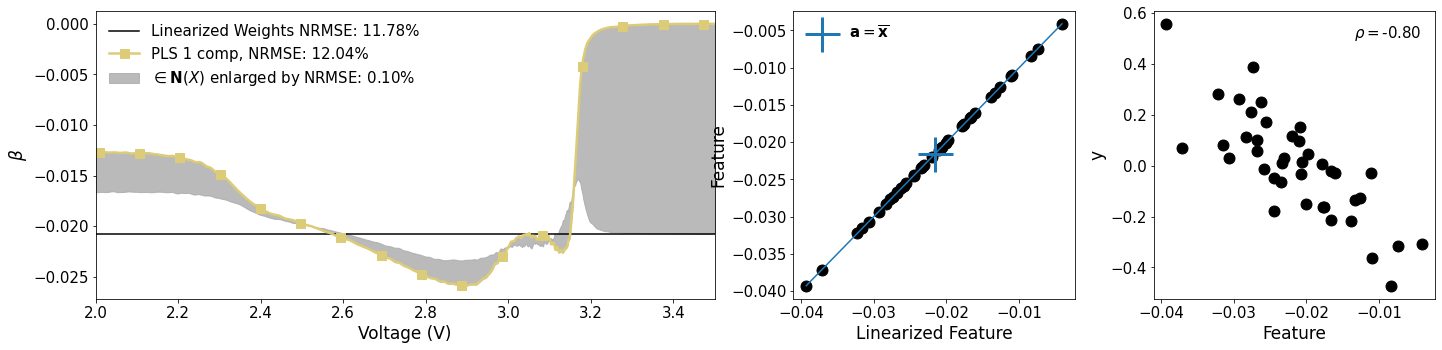

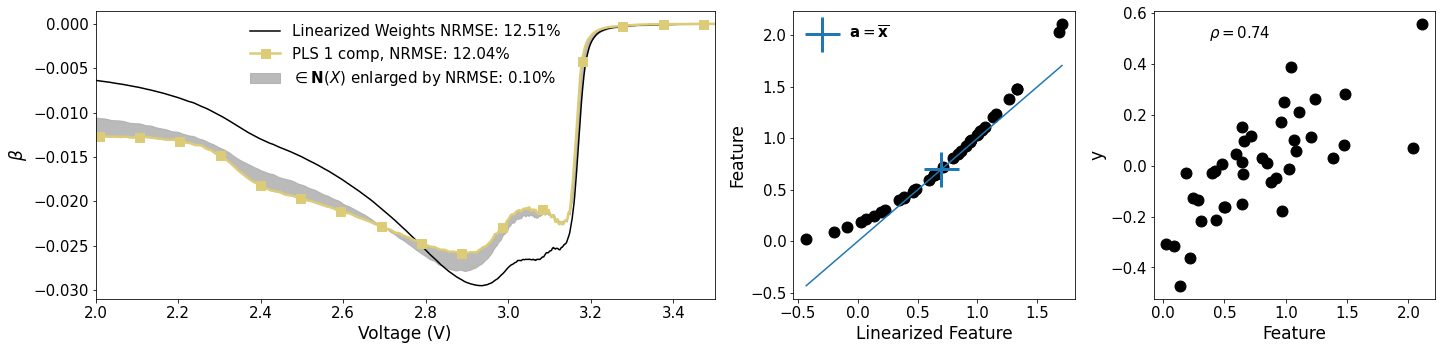

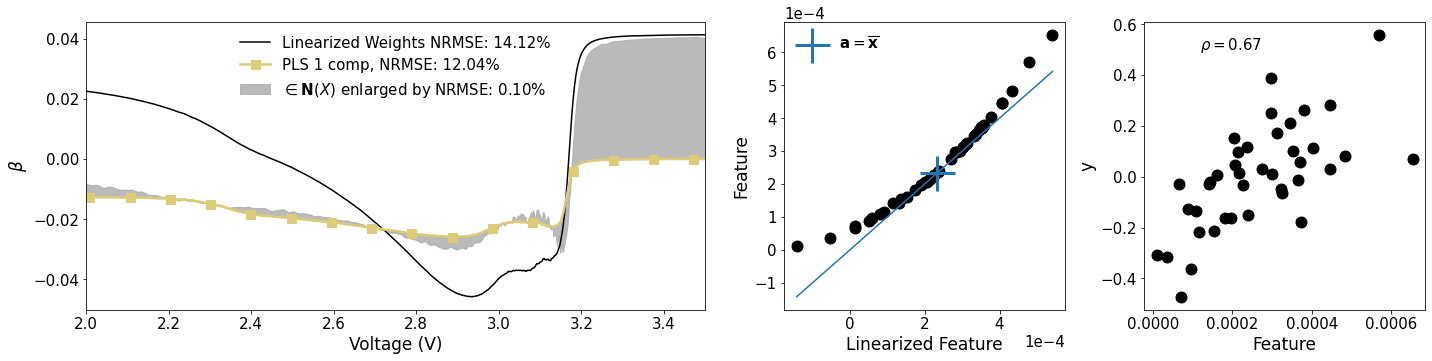

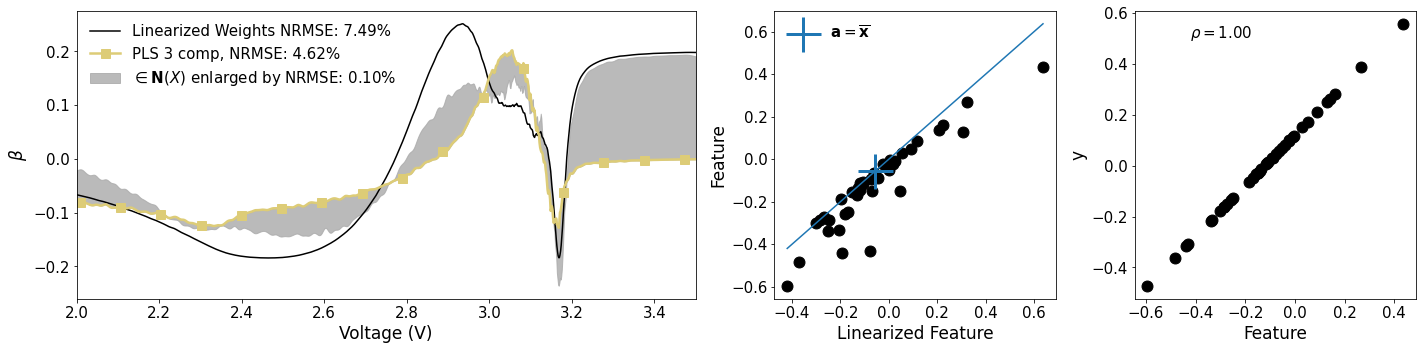

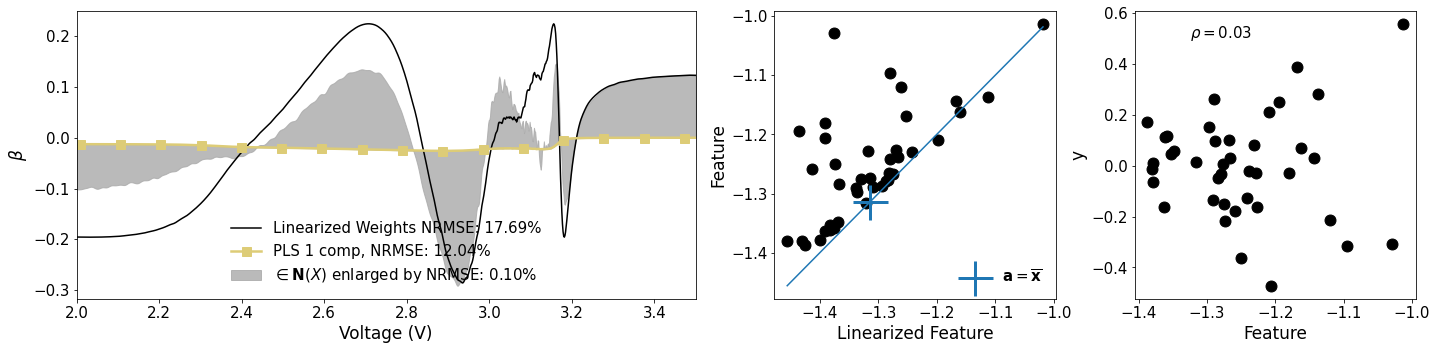

In [14]:
# Inititate the class with data (x, y) & features that you want to test
lfp_skew_gt = Featlin(data_obj=lfp_skew, feat_funcs=feat_fun_dict)

# Run the tests
lfp_skew_gt = lfp_skew_gt.analyze_all_features(opt_cv={'active':True, 'model': []}, opt_dist={'active':True, 'model': ['PLS']}, max_nrmse=0.1)
plt.show()

Iteration: 0 done
Iteration: 1 done
Iteration: 2 done
Iteration: 3 done
Converged after 3 iterations
['PLS 1 comp', 'lfun']
Gamma value corresponding to nrmse=1.0e-01 % is 127.031
Iteration: 0 done
Iteration: 1 done
Iteration: 2 done
Iteration: 3 done
Converged after 3 iterations
['PLS 1 comp', 'lfun']
Gamma value corresponding to nrmse=1.0e-01 % is 117.045
Iteration: 0 done
Iteration: 1 done
Iteration: 2 done
Iteration: 3 done
Converged after 3 iterations
['PLS 1 comp', 'lfun']
Gamma value corresponding to nrmse=1.0e-01 % is 34.718
Iteration: 0 done
Iteration: 1 done
Iteration: 2 done
Iteration: 3 done
Converged after 3 iterations
['PLS 1 comp', 'lfun']
Gamma value corresponding to nrmse=1.0e-01 % is 369.257
Iteration: 0 done
Iteration: 1 done
Iteration: 2 done
Iteration: 3 done
Converged after 3 iterations
['PLS 4 comp', 'lfun']
Gamma value corresponding to nrmse=1.0e-01 % is 1082.277


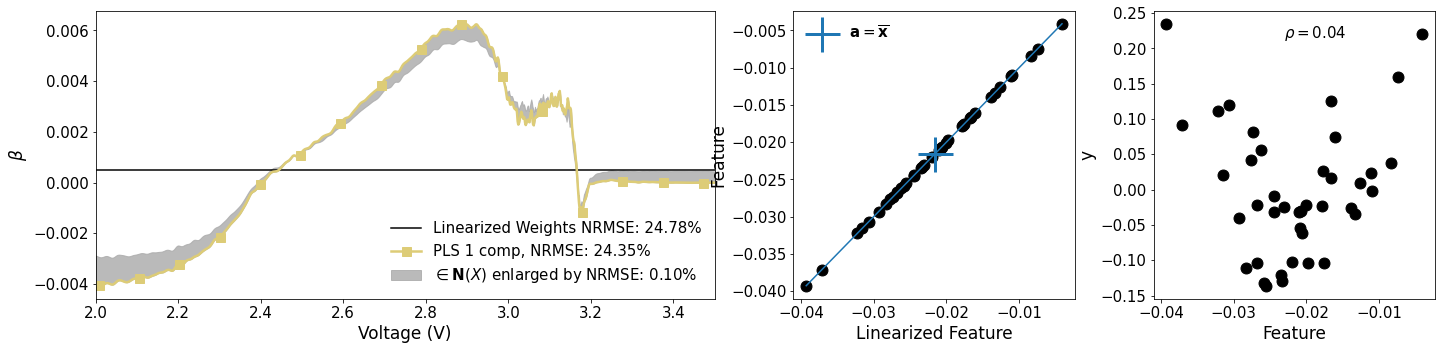

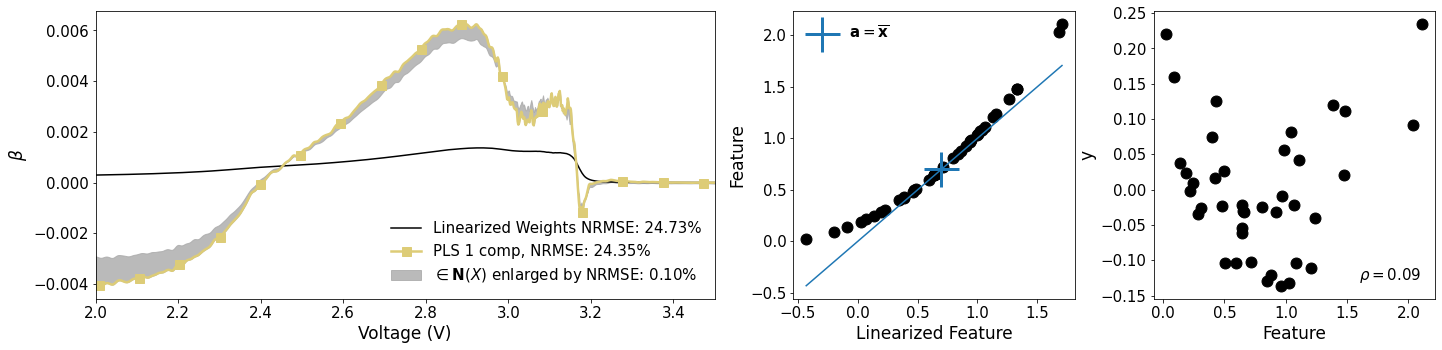

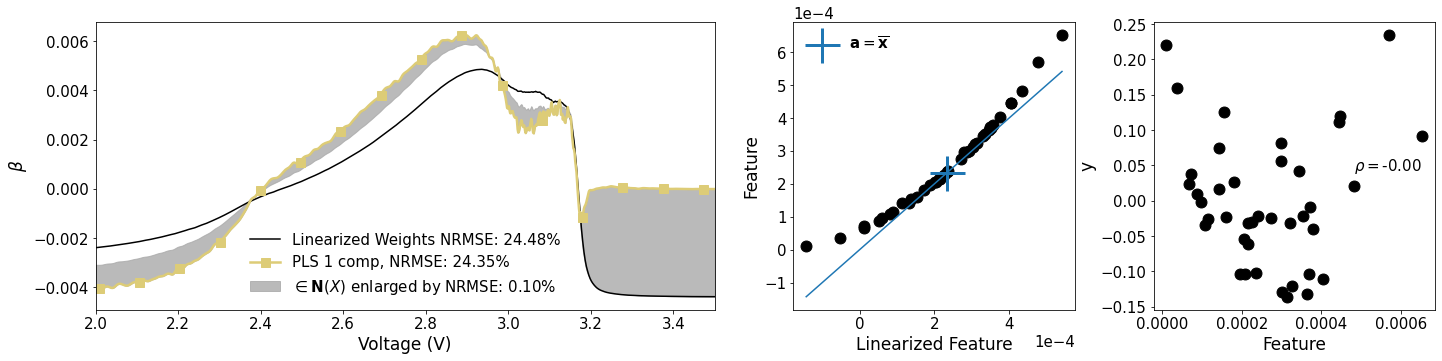

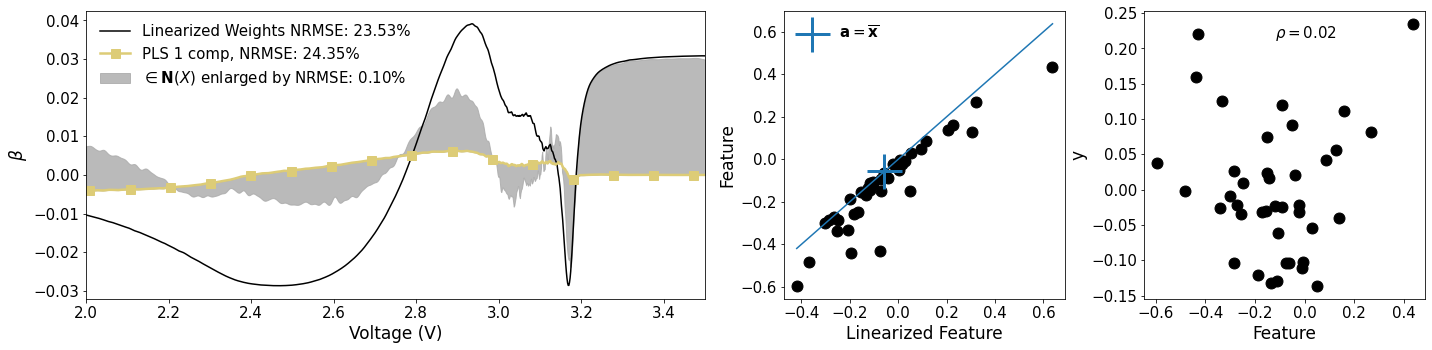

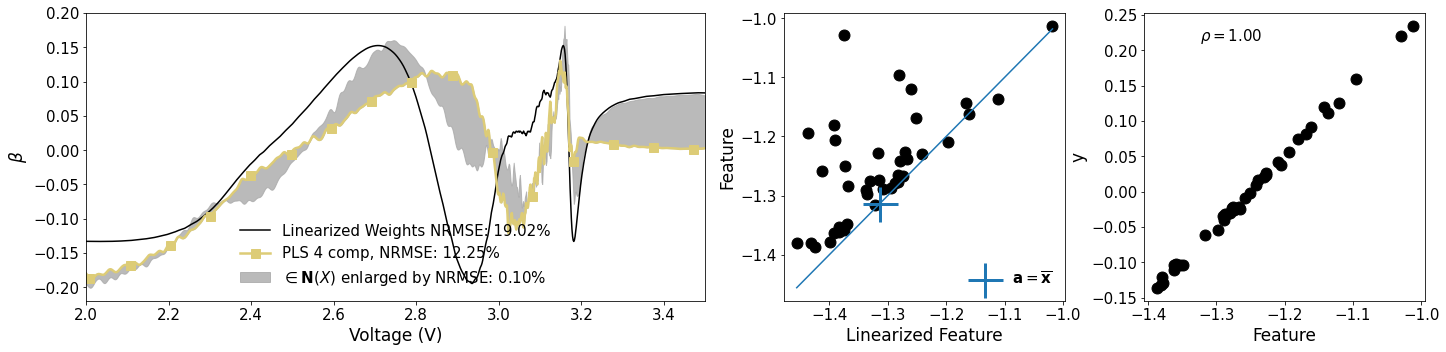

In [15]:
# Inititate the class with data (x, y) & features that you want to test
lfp_kurt_gt = Featlin(data_obj=lfp_kurt, feat_funcs=feat_fun_dict)

# Run the tests
lfp_kurt_gt = lfp_kurt_gt.analyze_all_features(opt_cv={'active':True, 'model': []}, opt_dist={'active':True, 'model': ['PLS']}, max_nrmse=0.1)
plt.show()

In [16]:
# Why don't the linear methods point into the directions that would be ideal?  
# The effect of 'outliers' ?

# Even in an ideal world this will not work too well. 
# Reasons: 
# 1. Nullspace of the data, 
# 2. The way of regularization will affed the shape of the coefficiencts a lot. 
# IF there's some linear order, the algorithms will always learn coefficients that have a similar shape as the data!
# How much are the algorithms affected by outliers? 
# How much are the algorithms affected by not standardizing the data
# How much does correlation between columns affect the results? 

# --> Conclusion: Interesting new perspective on interpretation of regression coefficients. 
# How do regression coeffcieints compare with standardizartion and without?

# How and when does the sign of regression coefficients flip?


# Conclusions: It can give you some directions that might be interesting. 
# HOWEVER: Regression coefficients often look similar to the data... 
# Why is this the case? 
# --> Because the data is not standardized, we apply an implicicit preference larger weights on regions that with a larger mean/std 
# Thsi regiosn might also contiana more information, but deu to the way how regularization is done, if the regions where the magnitude of the data is smaller 
# doesnt carry significatly more information, those will go to zero//they might be eassier to regularize down.

# Common issues with such datasets: 
# Correlation of columns. 